In [82]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

In [83]:
#data
df=pd.read_csv('C:\Kate\Python\Authorship Attribution\data\AllTweets.csv')

In [84]:
pd.DataFrame(df.groupby('author').size().rename('counts')).sort_values('counts', ascending=False)

,counts
author,
DonaldTrump,17216
NASA,15910
KimKardashian,10688
various,10440
FiveThirtyEight,9761
BarackObama,6896
RichardDawkins,5839
AdamSavage,4872
HillaryClinton,3356


In [85]:
import random
from sklearn.cross_validation import train_test_split
#1000 random sample rows for each author
df_new=pd.DataFrame()
twts_train=pd.DataFrame()
twts_test=pd.DataFrame()
author_train=pd.DataFrame()
author_test=pd.DataFrame()
for a in df.author.unique():
    rows = random.sample(list(df[df['author']==a].index), 1000)
    df_temp = df.ix[rows]
    df_new=df_new.append(df_temp,ignore_index=True)    
    X_train, X_test, Y_train, Y_test = train_test_split(df_temp.ix[:,['text']], df_temp.ix[:,['author']], test_size=0.2, random_state=42)
    twts_train=twts_train.append(X_train, verify_integrity=False)
    twts_test=twts_test.append(X_test, verify_integrity=False)
    author_train=author_train.append(Y_train, verify_integrity=False)
    author_test=author_test.append(Y_test, verify_integrity=False)

Train set:

In [86]:
print (len(twts_train),len(author_train))

(8800, 8800)


Test set:

In [87]:
print(len(twts_test),len(author_test))

(2200, 2200)


In [88]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    3. Stems
    4. Returns a list of the cleaned text
    """

    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    

    return text_processed

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

In [90]:
ScoreSummaryByModel = list()

In [91]:
def PredictionEvaluation(author_test_b,author_predicted_b,target_names,comment):
    Accuracy=accuracy_score(author_test_b,author_predicted_b)
    #print (Accuracy)
    Recall=recall_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (Recall)
    Precision=precision_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (Precision)
    F1=f1_score(author_test_b, author_predicted_b, labels=[0,1,2,3], average='macro')
    #print (F1)
    ScoreSummaryByModel.append([Accuracy,Recall,Precision,F1,comment])
    print(classification_report(author_test_b, author_predicted_b, target_names=target_names))

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

In [93]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [94]:
ScoreSummaryByModelParams=list()

In [95]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

In [96]:
def ModelParamsEvaluation (f_union,model,params,comment):
    pipeline = Pipeline([
    # Extract the text & text_coded
    # Use FeatureUnion to combine the features from different vectorizers
    ('union', f_union),
    # Use a  classifier on the combined features
    ('clf', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params, verbose=1)
    grid_search.fit(twts_train['text'], author_train['author'])
    author_predicted = grid_search.predict(twts_test['text'])
    lb = LabelBinarizer()
    author_test_b = lb.fit_transform(author_test['author'])
    author_predicted_b  = lb.fit_transform(author_predicted)
    #best score
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    author_names=grid_search.best_estimator_.named_steps['clf'].classes_

    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        ScoreSummaryByModelParams.append([comment,grid_search.best_score_,"\t%s: %r" % (param_name, best_parameters[param_name])]) 
    return (author_predicted,author_predicted_b,author_test_b,author_names)

In [97]:
f2_union=FeatureUnion(
        transformer_list=[
            # Pipeline for pulling char features  from the text
            ('char', Pipeline([
                ('tfidf',     TfidfVectorizer(analyzer='char',ngram_range=(3, 3))),
            ])),
            # Pipeline for pulling stememd word features from the text
            ('text', Pipeline([
                ('tfidf',    TfidfVectorizer(analyzer='word',tokenizer= text_process,ngram_range=(1, 1))),
            ])),        

        ],

    )

In [98]:
from sklearn.svm import LinearSVC
#LinearSVC
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation(f2_union,LinearSVC(),p,'LinearSVC')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   50.1s finished


Best score: 0.868
Best parameters set:
	clf__C: 1


In [99]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'LinearSVC')

                 precision    recall  f1-score   support

     AdamSavage       0.78      0.81      0.79       192
    BarackObama       0.88      0.91      0.89       193
    DonaldTrump       0.84      0.78      0.81       218
FiveThirtyEight       0.98      0.99      0.99       197
 HillaryClinton       0.86      0.84      0.85       205
  KimKardashian       0.84      0.88      0.86       191
           NASA       0.93      0.92      0.92       203
 RichardDawkins       0.82      0.82      0.82       200
     ScottKelly       0.84      0.91      0.87       184
  deGrasseTyson       0.82      0.75      0.78       218
        various       0.99      1.00      1.00       199

    avg / total       0.87      0.87      0.87      2200



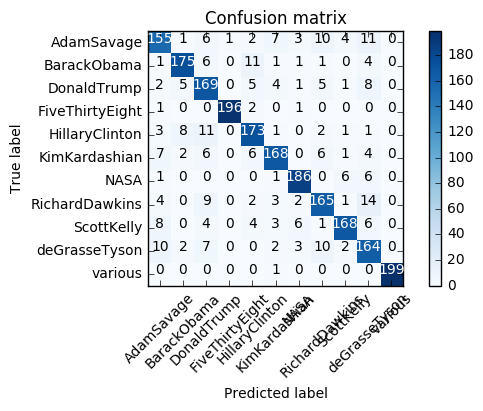

In [100]:
plot_confusion_matrix(confusion_matrix(author_test['author'], author_predicted), author_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [101]:
author_predicted=pd.DataFrame(author_predicted,columns=['predicted'])
df_wrong_result = pd.concat([twts_test.reset_index(),author_test.reset_index(),author_predicted], axis=1)
df_wrong_result.drop('index', axis=1, inplace=True)
df_wrong_result=df_wrong_result[df_wrong_result['author']!=df_wrong_result['predicted']]
df_wrong_result.head(10)

,text,author,predicted
7,"Big thanks to all our 338,655 followers. Just ...",NASA,deGrasseTyson
10,Spacewalk stats: Six hours 8 min/229th by US a...,NASA,deGrasseTyson
32,"@ethanrmatt That's true, the external tank is ...",NASA,deGrasseTyson
51,"@PuddleJumper8 To work in Mission Control, Hou...",NASA,ScottKelly
68,Grunsfeld also installed a soft capture mechan...,NASA,deGrasseTyson
79,"NASA astronaut Don Pettit, Russian cosmonaut O...",NASA,ScottKelly
105,Expedition 18 crew Mike Fincke and Yury Loncha...,NASA,ScottKelly
116,Follow Expedition 26 crew members @Astro_Cady ...,NASA,ScottKelly
120,"For #MartinLutherKingDay, here's a @Space_Stat...",NASA,ScottKelly
121,RT @SQLRockstar: A human being that waved hell...,NASA,deGrasseTyson


In [102]:
df_wrong_result[df_wrong_result['predicted']=='KimKardashian'].head(20)

,text,author,predicted
133,MT @chandraxray What says love better than a r...,NASA,KimKardashian
220,"Ryanseacrest, stop being weird with everyone. ...",AdamSavage,KimKardashian
248,RT @kenplume I'm still looking ////// Anyone k...,AdamSavage,KimKardashian
280,"Thing1:""why are they doubleparked"" Me: ""church...",AdamSavage,KimKardashian
297,I can’t WAIT to show you all what I’m doing to...,AdamSavage,KimKardashian
331,We had one day off from our tour so I came hom...,AdamSavage,KimKardashian
362,I'm going to be a guest judge for @BattleBots'...,AdamSavage,KimKardashian
395,@cerebus19 Interview was fun! Let's do it ag...,AdamSavage,KimKardashian
565,"@Rogerson_john sorry, PDF is no longer available",various,KimKardashian
754,Coffee and a handshake: http://instagr.am/p/OU...,BarackObama,KimKardashian


In [103]:
from sklearn.svm import SVC
p = {'clf__C': (1,0.1,0.01,0.001,0.0001)}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation(f2_union,SVC(kernel='linear'),p,'SVC, linear kernel')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 24.3min finished


Best score: 0.858
Best parameters set:
	clf__C: 1


In [104]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'SVC, linear kernel')

                 precision    recall  f1-score   support

     AdamSavage       0.77      0.74      0.75       208
    BarackObama       0.86      0.89      0.88       194
    DonaldTrump       0.83      0.75      0.79       223
FiveThirtyEight       0.98      1.00      0.99       196
 HillaryClinton       0.88      0.85      0.86       205
  KimKardashian       0.81      0.90      0.86       181
           NASA       0.92      0.94      0.93       195
 RichardDawkins       0.79      0.81      0.80       193
     ScottKelly       0.81      0.94      0.87       174
  deGrasseTyson       0.79      0.68      0.73       233
        various       0.99      1.00      0.99       198

    avg / total       0.86      0.86      0.86      2200



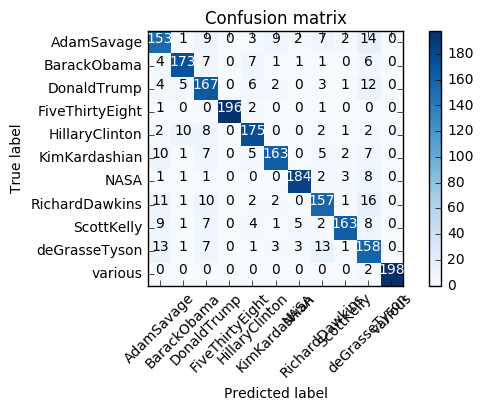

In [105]:
plot_confusion_matrix(confusion_matrix(author_test['author'], author_predicted), author_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [106]:
from sklearn.linear_model import SGDClassifier
p = {'clf__alpha': (0.01,0.001,0.0001,0.00001, 0.000001),
    'clf__penalty': ('l1','l2', 'elasticnet')}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation (f2_union,SGDClassifier(),p,'SGD Classifier')

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.3min finished


Best score: 0.861
Best parameters set:
	clf__alpha: 0.0001
	clf__penalty: 'elasticnet'


In [107]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'SGD Classifier')

                 precision    recall  f1-score   support

     AdamSavage       0.77      0.85      0.80       181
    BarackObama       0.85      0.91      0.88       186
    DonaldTrump       0.82      0.74      0.78       222
FiveThirtyEight       0.97      0.99      0.98       197
 HillaryClinton       0.88      0.80      0.84       219
  KimKardashian       0.86      0.86      0.86       201
           NASA       0.94      0.90      0.92       208
 RichardDawkins       0.80      0.86      0.83       187
     ScottKelly       0.84      0.93      0.89       181
  deGrasseTyson       0.83      0.76      0.79       219
        various       0.99      1.00      1.00       199

    avg / total       0.87      0.87      0.87      2200



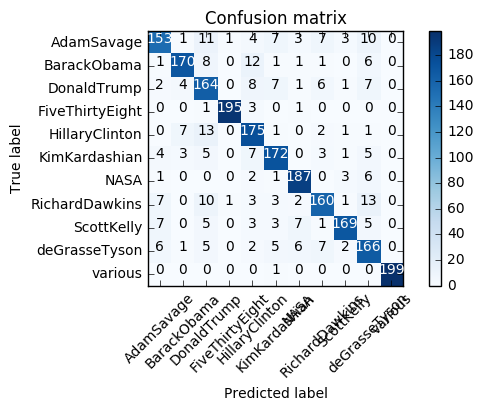

In [108]:
plot_confusion_matrix(confusion_matrix(author_test['author'], author_predicted), author_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [109]:
from sklearn.naive_bayes import BernoulliNB
p = {'clf__alpha': (1,0.1,0.01,0.001,0.0001,0)}
(author_predicted,author_predicted_b, author_test_b,author_names)=ModelParamsEvaluation(f2_union,BernoulliNB(),p,'Bernoulli Naive Bayes')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   49.2s finished


Best score: 0.849
Best parameters set:
	clf__alpha: 0.01


In [110]:
PredictionEvaluation(author_predicted_b, author_test_b,author_names,'Bernoulli Naive Bayes')

                 precision    recall  f1-score   support

     AdamSavage       0.69      0.76      0.72       184
    BarackObama       0.84      0.89      0.87       189
    DonaldTrump       0.85      0.70      0.77       243
FiveThirtyEight       0.97      1.00      0.99       195
 HillaryClinton       0.79      0.85      0.82       185
  KimKardashian       0.86      0.87      0.87       199
           NASA       0.90      0.93      0.92       193
 RichardDawkins       0.69      0.80      0.74       172
     ScottKelly       0.78      0.86      0.82       182
  deGrasseTyson       0.86      0.65      0.74       267
        various       0.95      1.00      0.98       191

    avg / total       0.84      0.84      0.84      2200



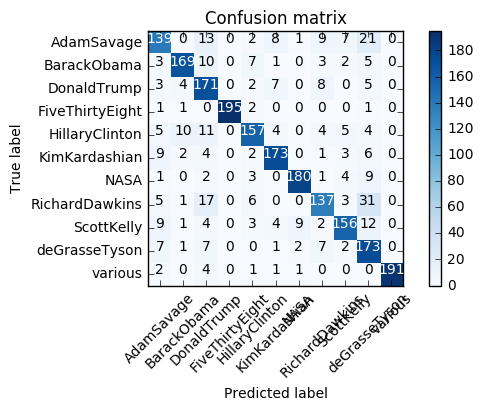

In [111]:
plot_confusion_matrix(confusion_matrix(author_test['author'], author_predicted), author_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

The best method is LinearSVC(C=1). 
SVC with the linear kernel shows worse result then LinearSVC. This is also different from binary classification. LinearSVC uses "one-vs-rest" (default) and SVC uses "one-vs-one" for multi-class. And SGDClassifier uses "one-vs-all" for multi-class classification

In [112]:
df_ScoreSummaryByModelParams=DataFrame(ScoreSummaryByModelParams,columns=['Method','BestScore','BestParameter'])
df_ScoreSummaryByModelParams.sort_values(['BestScore'],ascending=False,inplace=True)
df_ScoreSummaryByModelParams

,Method,BestScore,BestParameter
0,LinearSVC,0.867955,\tclf__C: 1
2,SGD Classifier,0.861250,\tclf__alpha: 0.0001
3,SGD Classifier,0.861250,\tclf__penalty: 'elasticnet'
1,"SVC, linear kernel",0.858182,\tclf__C: 1
4,Bernoulli Naive Bayes,0.848750,\tclf__alpha: 0.01


In [113]:
df_ScoreSummaryByModel=DataFrame(ScoreSummaryByModel,columns=['Precision','Accuracy','Recall','F1','Comment'])
df_ScoreSummaryByModel.sort_values(['F1'],ascending=False,inplace=True)
df_ScoreSummaryByModel

,Precision,Accuracy,Recall,F1,Comment
0,0.871818,0.874023,0.871818,0.872394,LinearSVC
2,0.868182,0.871729,0.868182,0.868846,SGD Classifier
1,0.857727,0.863852,0.857727,0.859506,"SVC, linear kernel"
3,0.836818,0.845959,0.836818,0.838380,Bernoulli Naive Bayes
